<a href="https://colab.research.google.com/github/dkalenov/Predictive-sales-forecast/blob/main/Predictive_sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive sales forecast

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler

## Functions for data processing and EDA

In [ ]:
# Function for displaying basic information about the dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def basic_data_preprocessing(dataframe):
    # Convert all column titles to lowercase with "_" between words
    dataframe.columns = [x.lower().replace(' ', '_') for x in dataframe.columns.values]

    # Basic information about the dataset
    rows_num, columns_num = dataframe.shape
    print(f'Number of records: {rows_num}')
    print(f'Number of columns: {columns_num}\n')
    print('-' * 75)

    # Dataset information
    print("\nDataset Information:")
    dataframe.info()
    print()
    print('-' * 75)

    # Checking for missing values
    missing_values = dataframe.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values:")
        display(pd.DataFrame(missing_values, columns=['Missing Count']))
        display(dataframe[dataframe.isna().any(axis=1)])
    else:
        print("No missing values.")
    print('-' * 75)

    # Checking for zero-filled columns
    zero_columns = dataframe.columns[(dataframe == 0.0).any()]
    zero_count = dataframe[zero_columns].apply(lambda x: x.value_counts().get(0, 0))
    if zero_count.sum() != 0:
        print('Rows with value 0 found:')
        display(pd.DataFrame(zero_count, columns=['Zero Count']))
    else:
        print('No rows with value 0.')
    print('-' * 75)

    # Checking for duplicates
    if dataframe.duplicated().sum() > 0:
        print("Duplicate data found. Number of duplicates:", dataframe.duplicated().sum())
        display(dataframe[dataframe.duplicated(keep=False)])
    else:
        print("No duplicates found.")
    print('-' * 75)

    # Checking for negative values in the dataframe
    # Excluding columns with string data type (object type)
    dataframe_digits = dataframe.select_dtypes(exclude=['object', 'datetime'])
    if (dataframe_digits < 0).sum().sum() > 0:
        print("Negative values found:")
        display(pd.DataFrame((dataframe_digits < 0).sum(), columns=['Negative Value Count']))
    else:
        print('No negative values found.')
    print('-' * 75)

    # Statistical description of the data
    print("\nStatistical Description of the Data:\n")
    display(dataframe.describe())
    print('-' * 75)

    # Data Distribution
    print("\nData Distribution:")

    # Determine the number of graphs and rows for the subplots
    num_graphs = len(dataframe.columns)
    num_rows = (num_graphs + 1) // 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 4))

    for i, column in enumerate(dataframe.columns):
        ax = axes[i // 2, i % 2]  # Get the current axis from the subplot grid

        # Categorical feature: countplot
        if dataframe[column].dtype == 'object':
            sns.countplot(data=dataframe, x=column, ax=ax, color='dodgerblue')
            ax.tick_params(axis='x')
            total = float(len(dataframe[column]))
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

        # Numeric feature with less than 8 unique values: countplot
        elif dataframe[column].dtype == 'datetime64[ns]':
            sns.histplot(data=dataframe, x=column, kde=True, ax=ax, color='dodgerblue')
        else:
            if len(dataframe[column].unique()) < 8:
                sns.countplot(data=dataframe, x=column, ax=ax, color='dodgerblue')
                ax.tick_params(axis='x')
                total = float(len(dataframe[column]))
                for p in ax.patches:
                    height = p.get_height()
                    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
            else:
                sns.histplot(data=dataframe, x=column, kde=True, ax=ax, color='dodgerblue')
                ax.axvline(dataframe[column].mean(), color='red', linestyle='--')
        # Set visualization properties for the current axis
        ax.grid(False)
        ax.set_title(column)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_facecolor('white')
        ax.tick_params(top=False, bottom=False, left=False, right=False)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
# Function for compression of the data type of columns in a pandas DataFrame

import pandas as pd
import numpy as np

def data_type_compression(dataframe):

    for column in dataframe.columns:
        unique_values = dataframe[column].unique()

        # Check if the column has two unique values (potentially a boolean column)
        # Uncomment the code below if you want to convert such columns to boolean type
        # if len(unique_values) == 2:
        #   dataframe[column] = dataframe[column].astype(bool)

        # Check if the column has an integer data type
        if dataframe[column].dtype == int:
            max_value = np.max(dataframe[column])

            # Assign the appropriate integer type based on the maximum value in the column
            if max_value <= np.iinfo(np.int8).max:
                dataframe[column] = dataframe[column].astype(np.int8)
            elif max_value <= np.iinfo(np.int16).max:
                dataframe[column] = dataframe[column].astype(np.int16)
            elif max_value <= np.iinfo(np.int32).max:
                dataframe[column] = dataframe[column].astype(np.int32)
            else:
                dataframe[column] = dataframe[column].astype(np.int64)

        # Check if the column has a float data type
        elif dataframe[column].dtype == float:
            max_value = np.max(dataframe[column])

            # Assign the appropriate float type based on the maximum value in the column
            if max_value <= np.finfo(np.float16).max:
                dataframe[column] = dataframe[column].astype(np.float16)
            elif max_value <= np.finfo(np.float32).max:
                dataframe[column] = dataframe[column].astype(np.float32)
            else:
                dataframe[column] = dataframe[column].astype(np.float64)

In [ ]:
# Function for visualizing the distribution of different features by a target feature

import matplotlib.pyplot as plt
import seaborn as sns

def data_distribution_by_target(dataframe, target_feature):
    for column in dataframe.columns:
        if column != target_feature:
            # Initialize plot outside of conditional statements
            plot = None

            # Create a new figure with size (8, 6)
            plt.figure(figsize=(8, 6))

            # Set style for grid (white with no grid lines)
            sns.set_style("whitegrid", {'axes.grid': False})

            # Categorical feature: barplot
            if dataframe[column].dtype == 'object':
                plot = sns.barplot(x=column, y=target_feature, data=dataframe)

            # Date/time feature: lineplot
            elif dataframe[column].dtype == 'datetime64[ns]':
                plt.xticks(rotation=45, ha='right')
                plot = sns.lineplot(x=column, y=target_feature, data=dataframe)

            # Boolean feature: barplot
            elif dataframe[column].dtype == 'bool':
                plt.xticks([0, 1], ['False', 'True'])
                plot = sns.barplot(x=column, y=target_feature, data=dataframe)

            # Numeric feature: histogram with kernel density estimation (kde)
            elif dataframe[column].dtype in ['float64', 'float32', 'float16']:
                n_bins = min(30, len(dataframe[column].unique()))
                binwidth = (dataframe[column].max() - dataframe[column].min()) / n_bins
                binrange = (dataframe[column].min(), dataframe[column].max())
                sns.histplot(data=dataframe, x=column, bins=n_bins, binwidth=binwidth, binrange=binrange, kde=True, cumulative=False)
                plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)

            # Other feature types: scatterplot with regression line or countplot
            else:
                if dataframe[column].nunique() > 6:
                    plot = sns.scatterplot(data=dataframe, x=column, y=target_feature, alpha=0.7)
                    sns.regplot(data=dataframe, x=column, y=target_feature, scatter=False, lowess=True, line_kws={"color": "C1"})
                    plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)
                else:
                    plot = sns.countplot(data=dataframe, x=column)

            # Check if plot is assigned before setting properties
            if plot is not None:
                plot.set_title(f'Data Distribution by {target_feature}: {column}')
                plot.set_xlabel(column)
                plot.set_ylabel(target_feature)
                plt.tight_layout()
                plt.show()



In [ ]:
# Function for detecting outliers in a dataframe
# Displays boxplots and a table with outlier information

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def detect_outliers(dataframe):
    outlier_table = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Percentage'])  # Creating a DataFrame to store outlier information

    for column in dataframe.columns:
        if dataframe[column].dtype != 'object' and len(dataframe[column].unique()) == 2:  # Checking for columns with binary values
            print(f"No outliers in column '{column}' as it has binary values.")  # Printing a message indicating binary values
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': ['NaN'],
                                       'Outlier Percentage': ['NaN']})],
                                       ignore_index=True)  # Updating the outlier table with binary value information
            print('*' * 75)
            print()
            continue  # Skipping to the next iteration if the column has binary values

        # skipping the object type
        if dataframe[column].dtype == 'object':
            break

        q1 = dataframe[column].quantile(0.25)  # Calculating the first quartile
        q3 = dataframe[column].quantile(0.75)  # Calculating the third quartile
        iqr = q3 - q1  # Calculating the interquartile range
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Counting the number of outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        num_outliers = len(outliers)
        column_len = len(dataframe[column])

        if num_outliers == 0:
            print(f"No outliers in column '{column}'.")
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                                    'Outlier Count': [0],
                                                    'Outlier Percentage': [0]})],
                                                    ignore_index=True)  # Updating the outlier table with outlier count
        else:
            print(f"Outliers in column '{column}':")
            print(f"Outlier Count: {num_outliers}")
            print(f"Outlier Percentage of total observations: {(num_outliers / column_len) * 100:.2f}%")  # Calculating and displaying outlier percentage
            print("Outlier Values:", ", ".join(outliers[column].astype(str)))

            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': [num_outliers],
                                       'Outlier Percentage': [(num_outliers / column_len) * 100]})],
                                       ignore_index=True)  # Updating the outlier table with outlier information

            # Plotting the boxplot with outliers
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.boxplot(data=dataframe, x=column, ax=ax)
            ax.set_title(f"Outlier Plot for column '{column}'")
            plt.show()

        print('*' * 75)
        print()

    display(outlier_table)

In [ ]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if corr_value is not None and apply_abs:
                  corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))

    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

In [ ]:
# Function to find multicollinearity and print correlation matrix

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix

def find_multicollinearity(dataframe, methods=['phik'], threshold=0.8):
    # List to store all multicollinear tables
    multicollinear_tables = []

    # Iterate through each method in the list of methods
    for method in methods:
        # Convert method to lowercase
        method = method.lower()

        # Calculate correlation matrix using specified sort method
        if method in ['pearson', 'kendall', 'spearman']:
            corr_matrix = dataframe.corr(method=method).abs()
        elif method == 'phik':
            interval_cols = [col for col in dataframe.columns]
            corr_matrix = phik_matrix(dataframe, interval_cols=interval_cols)
        else:
            print(f"Invalid method: {method}")
            continue

        # Exclude correlation of a variable with itself
        np.fill_diagonal(corr_matrix.values, np.NaN)

        # Create a larger figure size based on the number of features
        n = corr_matrix.shape[0]
        fig_width = 6 + n * 0.5
        fig_height = 4 + n * 0.3

        # Plot correlation matrix as heatmap with adjusted figure size
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=np.isnan(corr_matrix))
        plt.title(f"Correlation Matrix ({method})")
        plt.show()

        # Initialize an empty list to store multicollinear features
        multicollinear_table = []

        # Iterate through each pair of multicollinear features and their correlation percentages
        for i in range(n):
            for j in range(i+1, n):
                # Check if the correlation between the two features is above the threshold
                if corr_matrix.iloc[i, j] > threshold:
                    feature1 = corr_matrix.columns[i]
                    feature2 = corr_matrix.columns[j]
                    # Append the pair of multicollinear features and their correlation percentage to the list
                    multicollinear_table.append({'Feature 1': feature1, 'Feature 2': feature2, 'Correlation': corr_matrix.iloc[i, j]})

        # Create a dataframe from the list of multicollinear features
        multicollinear_table = pd.DataFrame(multicollinear_table)

        if not multicollinear_table.empty:
            # Sort the multicollinear table by correlation in descending order
            multicollinear_table = multicollinear_table.sort_values(by='Correlation', ascending=False)
            # Append the multicollinear table to the list of multicollinear tables
            multicollinear_tables.append((method, multicollinear_table))

    # Print all multicollinear tables
    if multicollinear_tables:
        for method, table in multicollinear_tables:
            print(f"\nMulticollinearity Table ({method})")
            display(table)
    else:
        print("\nNo features with high multicollinearity!")

## Data Extraction

In [ ]:
data_tn = pd.read_csv('Train Predictive sales forecast.csv')
data_tn.head(3)

,Week,SKU,Customer,Unit Price ($),Units sold ('000s)
0,31/Mar/2019,SKU01001,CUS09005,4.99,13.0
1,07/Apr/2019,SKU01001,CUS09005,4.99,12.9
2,14/Apr/2019,SKU01001,CUS09005,4.99,14.8


In [ ]:
data_tt = pd.read_csv('Test Predictive sales forecast.csv')
data_tt.head(3)

,Week,SKU,Customer,Unit Price,Predicted units sold(000s)
0,28/Apr/2024,SKU01001,CUS09005,8.98,???
1,05/May/2024,SKU01001,CUS09005,8.98,???
2,12/May/2024,SKU01001,CUS09005,8.98,???


## Data Preprocessing

In [ ]:
df_train = data_tn.copy()
df_test = data_tt.copy()

In [ ]:
# Remove unnecessary columns

df_train = df_train.drop(columns=['SKU', 'Customer'])
df_test = df_test.drop(columns=['SKU', 'Customer'])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week                265 non-null    object 
 1   Unit Price ($)      265 non-null    float64
 2   Units sold ('000s)  265 non-null    float64
dtypes: float64(2), object(1)
memory usage: 6.3+ KB


### Datetime managment

In [ ]:
df_train['Week'] = pd.to_datetime(df_train['Week'], format='%d/%b/%Y')
df_train.head(3)

,Week,Unit Price ($),Units sold ('000s)
0,2019-03-31,4.99,13.0
1,2019-04-07,4.99,12.9
2,2019-04-14,4.99,14.8


In [ ]:
df_train_fullweek = df_train.copy()

In [ ]:
# Create new columns for year, month, and day of the week
df_train_fullweek['Year'] = df_train_fullweek['Week'].dt.year
df_train_fullweek['Month'] = df_train_fullweek['Week'].dt.month
df_train_fullweek['Day_of_week'] = df_train_fullweek['Week'].dt.dayofweek  # 0 - Monday, 6 - Sunday

# Print the first few rows to check
print(df_train_fullweek.head(15))

         Week  Unit Price ($)  Units sold ('000s)  Year  Month  Day_of_week
0  2019-03-31            4.99                13.0  2019      3            6
1  2019-04-07            4.99                12.9  2019      4            6
2  2019-04-14            4.99                14.8  2019      4            6
3  2019-04-21            4.99                13.6  2019      4            6
4  2019-04-28            4.99                15.0  2019      4            6
5  2019-05-05            4.98                13.0  2019      5            6
6  2019-05-12            4.99                15.2  2019      5            6
7  2019-05-19            4.98                11.4  2019      5            6
8  2019-05-26            4.99                14.3  2019      5            6
9  2019-06-02            4.99                15.5  2019      6            6
10 2019-06-09            4.99                13.7  2019      6            6
11 2019-06-16            4.99                15.5  2019      6            6
12 2019-06-2

Sales always occur on the same day, so let's remove the column with the day of the week

In [ ]:
df_train_fullweek.drop(columns=['Week', 'Day_of_week'], inplace=True)
df_train_fullweek.head()

,Unit Price ($),Units sold ('000s),Year,Month
0,4.99,13.0,2019,3
1,4.99,12.9,2019,4
2,4.99,14.8,2019,4
3,4.99,13.6,2019,4
4,4.99,15.0,2019,4


In [ ]:
# df_test['Week'] = pd.to_datetime(df_test['Week'].str.lower(), format='%d/%b/%Y')
# df_test.head(3)

In [ ]:
month_mapping = {
    'january': 'Jan',
    'february': 'Feb',
    'march': 'Mar',
    'april': 'Apr',
    'may': 'May',
    'june': 'Jun',
    'july': 'Jul',
    'august': 'Aug',
    'september': 'Sep',
    'october': 'Oct',
    'november': 'Nov',
    'december': 'Dec'
}

In [ ]:
df_test['Week'] = df_test['Week'].str.lower().replace(month_mapping, regex=True)

In [ ]:
df_test['Week'] = pd.to_datetime(df_test['Week'], format='%d/%b/%Y')
df_test.head(3)

,Week,Unit Price,Predicted units sold(000s)
0,2024-04-28,8.98,???
1,2024-05-05,8.98,???
2,2024-05-12,8.98,???


In [ ]:
df_test_fullweek = df_test.copy()

In [ ]:
# Create new columns for year, month, and day of the week
df_test_fullweek['Year'] = df_test_fullweek['Week'].dt.year
df_test_fullweek['Month'] = df_test_fullweek['Week'].dt.month
df_test_fullweek['Day_of_week'] = df_test_fullweek['Week'].dt.dayofweek  # 0 - Monday, 6 - Sunday

# Print the first few rows to check
print(df_test_fullweek.head(15))

         Week  Unit Price Predicted units sold(000s)  Year  Month  Day_of_week
0  2024-04-28       8.980                        ???  2024      4            6
1  2024-05-05       8.980                        ???  2024      5            6
2  2024-05-12       8.980                        ???  2024      5            6
3  2024-05-19       5.388                        ???  2024      5            6
4  2024-05-26       8.980                        ???  2024      5            6
5  2024-06-02       8.980                        ???  2024      6            6
6  2024-06-09       8.980                        ???  2024      6            6
7  2024-06-16       7.900                        ???  2024      6            6
8  2024-06-23       7.900                        ???  2024      6            6
9  2024-06-30       8.980                        ???  2024      6            6
10 2024-07-07       8.980                        ???  2024      7            6
11 2024-07-14       8.980                        ???

In [ ]:
df_test_fullweek.drop(columns=['Week', 'Day_of_week'], inplace=True)
df_test_fullweek.head()

,Unit Price,Predicted units sold(000s),Year,Month
0,8.980,???,2024,4
1,8.980,???,2024,5
2,8.980,???,2024,5
3,5.388,???,2024,5
4,8.980,???,2024,5


## EDA

### Basic Data Analysis

Number of records: 265
Number of columns: 4

---------------------------------------------------------------------------

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unit_price_($)      265 non-null    float64
 1   units_sold_('000s)  265 non-null    float64
 2   year                265 non-null    int32  
 3   month               265 non-null    int32  
dtypes: float64(2), int32(2)
memory usage: 6.3 KB

---------------------------------------------------------------------------
No missing values.
---------------------------------------------------------------------------
No rows with value 0.
---------------------------------------------------------------------------
Duplicate data found. Number of duplicates: 4


,unit_price_($),units_sold_('000s),year,month
9,4.99,15.5,2019,6
11,4.99,15.5,2019,6
31,5.98,9.8,2019,11
33,5.98,9.8,2019,11
57,6.47,15.5,2020,5
59,6.47,15.5,2020,5
70,6.48,11.9,2020,8
72,6.48,11.9,2020,8


---------------------------------------------------------------------------
No negative values found.
---------------------------------------------------------------------------

Statistical Description of the Data:



,unit_price_($),units_sold_('000s),year,month
count,265.000000,265.000000,265.000000,265.000000
mean,6.904151,11.527547,2021.279245,6.464151
std,1.180810,5.050393,1.506722,3.453100
min,4.980000,3.700000,2019.000000,1.000000
25%,6.290000,8.100000,2020.000000,4.000000
50%,6.490000,10.300000,2021.000000,6.000000
75%,7.500000,13.300000,2023.000000,9.000000
max,9.000000,36.300000,2024.000000,12.000000


---------------------------------------------------------------------------

Data Distribution:


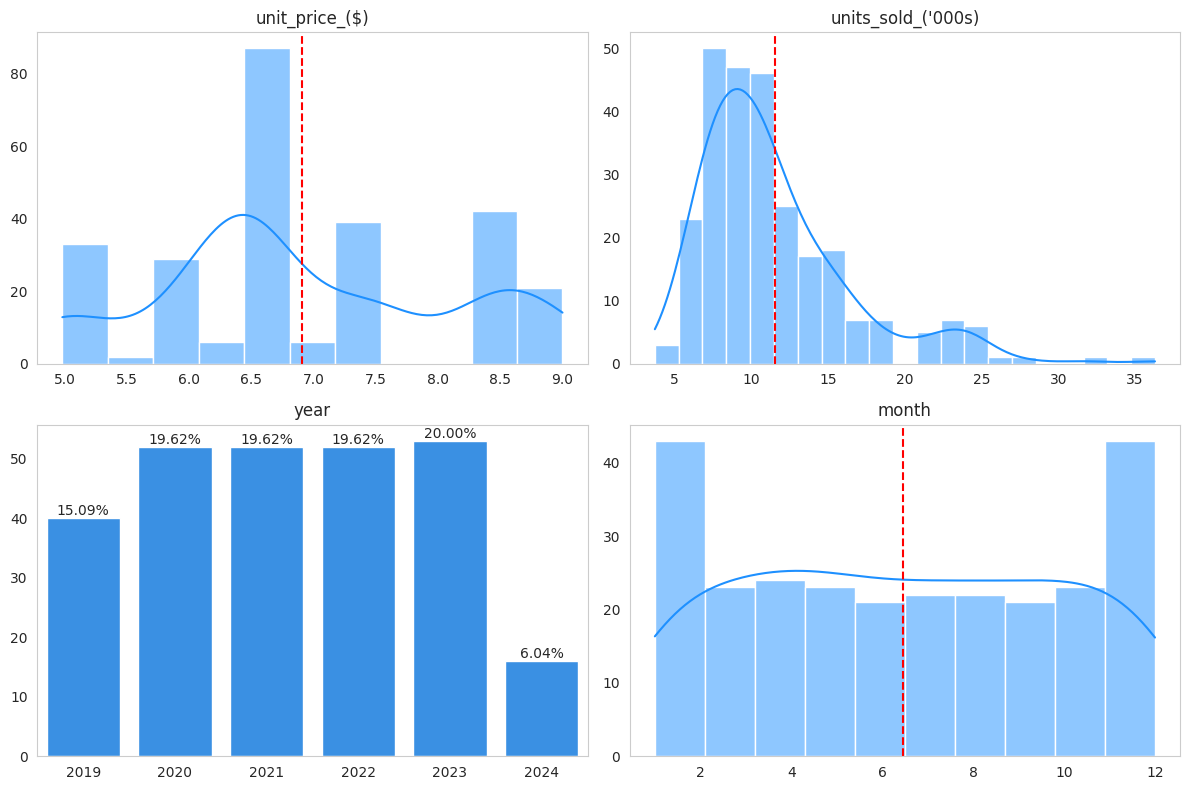

In [ ]:
basic_data_preprocessing(df_train_fullweek)

In [ ]:
df_train_fullweek.columns

Index(['unit_price_($)', 'units_sold_('000s)', 'year', 'month'], dtype='object')

In [ ]:
df_train_fullweek.rename(columns={'unit_price_($)': 'unit_price', "units_sold_('000s)": "units_sold"}, inplace=True)
df_train_fullweek

,unit_price,units_sold,year,month
0,4.99,13.0,2019,3
1,4.99,12.9,2019,4
2,4.99,14.8,2019,4
3,4.99,13.6,2019,4
4,4.99,15.0,2019,4
...,...,...,...,...
260,8.99,5.9,2024,3
261,7.18,18.3,2024,3
262,8.96,6.9,2024,4
263,9.00,7.5,2024,4


In [ ]:
df_test_fullweek.rename(columns={'Unit Price': 'unit_price', "Predicted units sold(000s)": "units_sold", "Year": "year", "Month": "month"}, inplace=True)
df_test_fullweek.head(3)

,unit_price,units_sold,year,month
0,8.98,???,2024,4
1,8.98,???,2024,5
2,8.98,???,2024,5


### Distribution by Target

In [ ]:
df_train_fullweek.columns

Index(['unit_price', 'units_sold', 'year', 'month'], dtype='object')

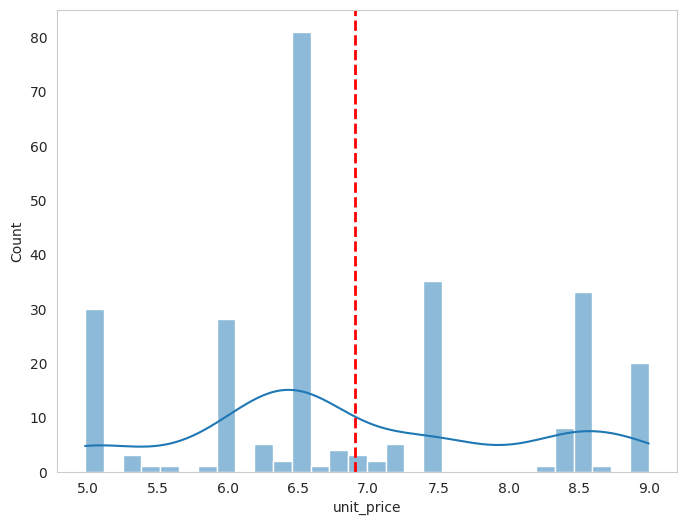

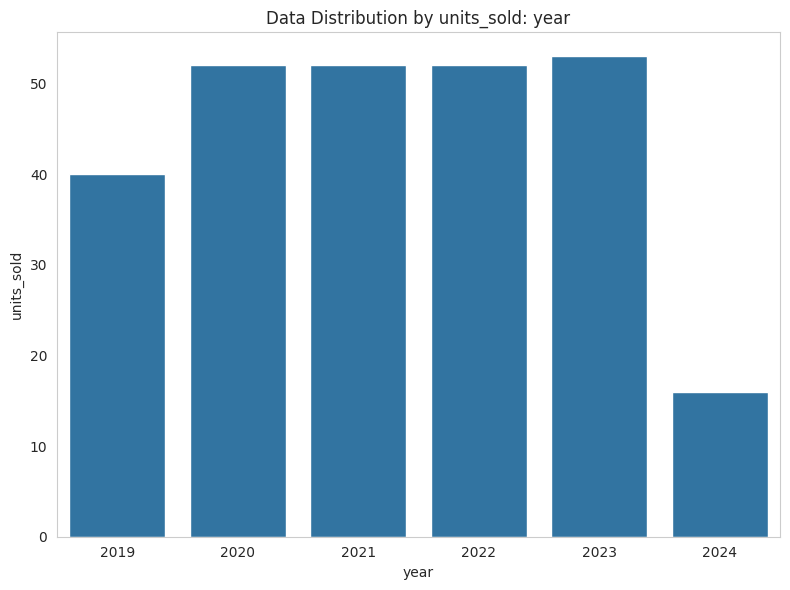

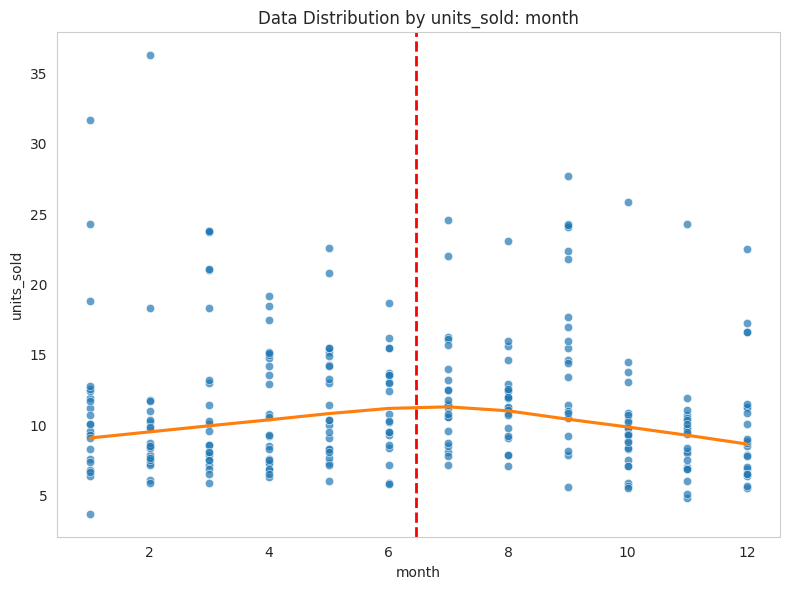

In [ ]:
data_distribution_by_target(df_train_fullweek, "units_sold")

### Outliers

No outliers in column 'unit_price'.
***************************************************************************

Outliers in column 'units_sold':
Outlier Count: 19
Outlier Percentage of total observations: 7.17%
Outlier Values: 23.8, 23.7, 24.3, 22.4, 24.1, 31.7, 22.6, 24.6, 27.7, 21.8, 36.3, 23.8, 22.0, 23.1, 24.2, 25.9, 24.3, 22.5, 24.3


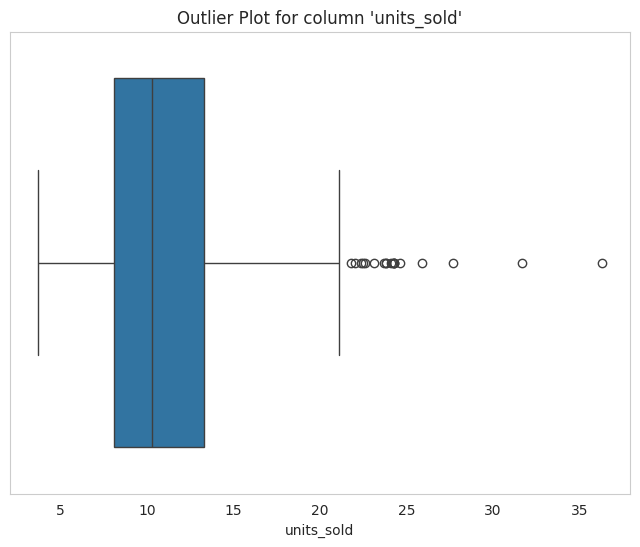

***************************************************************************

No outliers in column 'year'.
***************************************************************************

No outliers in column 'month'.
***************************************************************************



,Column,Outlier Count,Outlier Percentage
0,unit_price,0,0
1,units_sold,19,7.169811
2,year,0,0
3,month,0,0


In [ ]:
 detect_outliers(df_train_fullweek)

Outliers in column 'Unit Price':
Outlier Count: 8
Outlier Percentage of total observations: 15.09%
Outlier Values: 5.388, 7.9, 7.9, 7.5, 7.184, 5.688, 5.688, 4.74


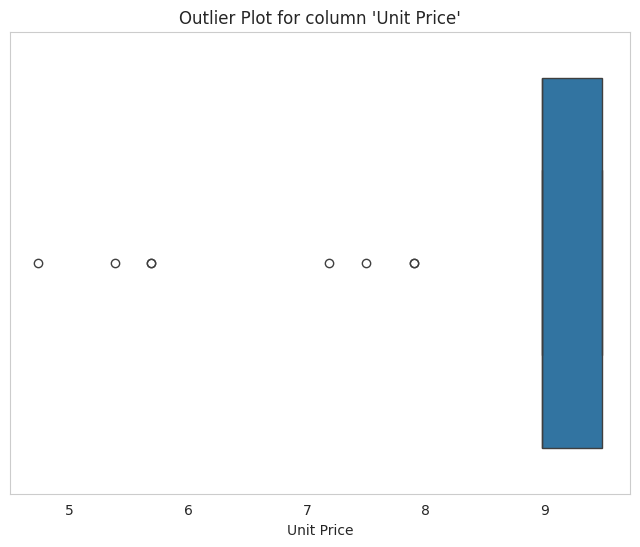

***************************************************************************



,Column,Outlier Count,Outlier Percentage
0,Unit Price,8,15.09434


In [ ]:
 detect_outliers(df_test_fullweek)

In [ ]:
# Find the rows with outliers in the 'units_sold' column
outliers = [23.8, 23.7, 24.3, 22.4, 24.1, 31.7, 22.6, 24.6, 27.7, 21.8, 36.3, 23.8, 22.0, 23.1, 24.2, 25.9, 24.3, 22.5, 24.3]
outlier_rows = df_train_fullweek[df_train_fullweek['units_sold'].isin(outliers)]

# Print the rows with outliers
print("Rows with outliers:")
outlier_rows

Rows with outliers:


,unit_price,units_sold,year,month
50,6.48,23.8,2020,3
51,6.48,23.7,2020,3
127,5.28,24.3,2021,9
128,5.26,22.4,2021,9
129,5.27,24.1,2021,9
147,5.00,31.7,2022,1
164,5.99,22.6,2022,5
170,5.98,24.6,2022,7
179,6.25,27.7,2022,9
180,6.29,21.8,2022,9


There are a lot of outliers which may affect the accuracy of the model. Let's create a second dataset with removed outliers.

In [ ]:
# Find the indices of rows containing outliers in the 'units_sold' column
outlier_indices = outlier_rows.index

# Drop rows with outlier indices from the DataFrame
df_cleaned = df_train_fullweek.drop(outlier_indices)

# Reset the index of the cleaned DataFrame
df_cleaned.reset_index(drop=True, inplace=True)

# Print the cleaned DataFrame
print("Cleaned DataFrame:")
df_cleaned.head(3)

Cleaned DataFrame:


,unit_price,units_sold,year,month
0,4.99,13.0,2019,3
1,4.99,12.9,2019,4
2,4.99,14.8,2019,4


In [ ]:
df_cleaned.shape

(246, 4)

### Correlation

<ipython-input-126-e9bbcc9d43e7>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
<ipython-input-126-e9bbcc9d43e7>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)


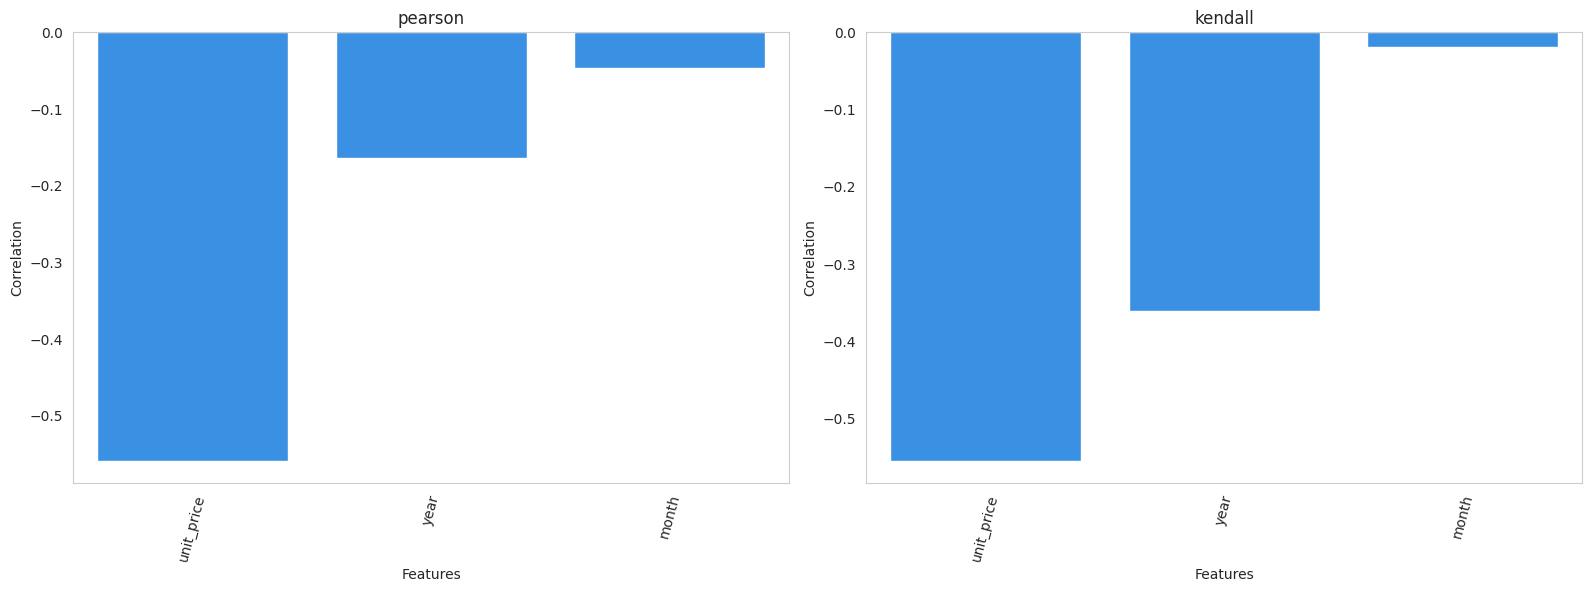

Correlation table with target feature 'units_sold':


Correlation Type,pearson,kendall
Column,,
month,-0.046956,-0.019597
year,-0.164585,-0.360560
unit_price,-0.559719,-0.555306



Top 2 features with highest correlation (Pearson): ['unit_price', 'year']

Top 2 features with highest correlation (Kendall): ['unit_price', 'year']


In [ ]:
correlation_analysis(df_train_fullweek, "units_sold", correlation_types=['pearson', 'kendall'], apply_abs=False)

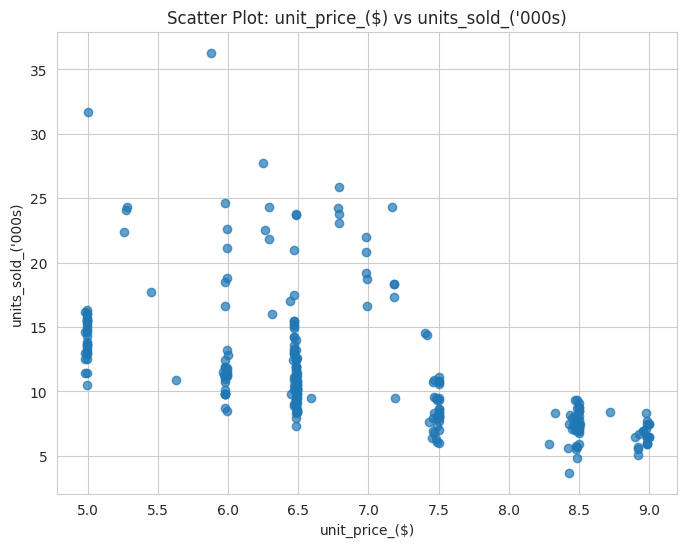

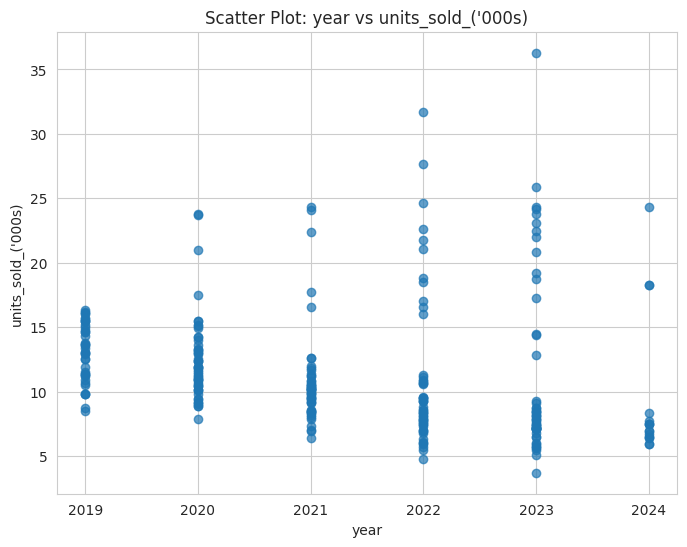

In [ ]:
# Scatter plot for unit_price_($) vs target_feature
plt.figure(figsize=(8, 6))
plt.scatter(df_train_fullweek['unit_price_($)'], df_train_fullweek['units_sold_(\'000s)'], alpha=0.7)
plt.title('Scatter Plot: unit_price_($) vs units_sold_(\'000s)')
plt.xlabel('unit_price_($)')
plt.ylabel('units_sold_(\'000s)')
plt.grid(True)
plt.show()

# Scatter plot for year vs target_feature
plt.figure(figsize=(8, 6))
plt.scatter(df_train_fullweek['year'], df_train_fullweek['units_sold_(\'000s)'], alpha=0.7)
plt.title('Scatter Plot: year vs units_sold_(\'000s)')
plt.xlabel('year')
plt.ylabel('units_sold_(\'000s)')
plt.grid(True)
plt.show()

## Models Train

In [ ]:
# Create a dataframe for storing the models' results

# Creating a dataframe
models_df = pd.DataFrame(columns=['Model', 'R2', 'MAE', 'MAPE', 'Special model parameters'])

### Data splitting

In [ ]:
data_train = df_train_fullweek.copy()
data_test = df_test_fullweek.copy()

display(data_train.head(3))
display(data_test.head(3))
display(df_cleaned.head(3))

,unit_price,units_sold,year,month
0,4.99,13.0,2019,3
1,4.99,12.9,2019,4
2,4.99,14.8,2019,4


,unit_price,units_sold,year,month
0,8.98,???,2024,4
1,8.98,???,2024,5
2,8.98,???,2024,5


,unit_price,units_sold,year,month
0,4.99,13.0,2019,3
1,4.99,12.9,2019,4
2,4.99,14.8,2019,4


In [ ]:
# Split the data into features (X) and target variable (y)
X = data_train.drop('units_sold', axis=1)
y = data_train['units_sold']

print(X.shape)
print(y.shape)

(265, 3)
(265,)


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of StandardScaler
scaler = MinMaxScaler()

# Standardize the training data
X_train_scaled = scaler.fit_transform(X_train)

# Standardize the test data
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Split the data into features (X) and target variable (y)
X_cleaned = df_cleaned.drop('units_sold', axis=1)
y_cleaned = df_cleaned['units_sold']

print(X_cleaned.shape)
print(y_cleaned.shape)

(246, 3)
(246,)


In [ ]:
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of StandardScaler
scaler = MinMaxScaler()

# Standardize the training data
X_train_cleaned_scaled = scaler.fit_transform(X_train)

# Standardize the test data
X_test_cleaned_scaled = scaler.transform(X_test)

### Baseline models

##### Full data

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_predict
import pandas as pd

# Define regression models
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(verbosity=-1, random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)
}

reports = []

# Iterate over models
for name, model in models.items():
    print(name)
    # Predict using cross-validation
    y_pred_train = cross_val_predict(estimator=model, X=X_train_scaled, y=y_train, cv=5)
    y_pred_test = cross_val_predict(estimator=model, X=X_test_scaled, y=y_test, cv=5)

    # Calculate metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

    # Print and store results
    print(f"Train - R2: {r2_train}, MAE: {mae_train}, MAPE: {mape_train}")
    print(f"Test - R2: {r2_test}, MAE: {mae_test}, MAPE: {mape_test}")
    print('---' * 25)

    report_dict = {
        'Name': name,
        'R2 Train': r2_train,
        'R2 Test': r2_test,
        'MAE Train': mae_train,
        'MAE Test': mae_test,
        'MAPE Train': mape_train,
        'MAPE Test': mape_test
    }

    reports.append(report_dict)

# Create DataFrame and display
reports_df = pd.DataFrame(reports)
sorted_df = reports_df.sort_values(by='R2 Test', ascending=False)
display(sorted_df)

LinearRegression
Train - R2: 0.6065325803088987, MAE: 2.2192743007031837, MAPE: 0.19652016978914474
Test - R2: 0.44654982275403066, MAE: 2.297098257889817, MAPE: 0.19903717143236274
---------------------------------------------------------------------------
DecisionTreeRegressor
Train - R2: 0.647595474222002, MAE: 1.8250393081761005, MAPE: 0.16237862032035327
Test - R2: -0.22578275595515152, MAE: 3.041509433962264, MAPE: 0.2309370781921557
---------------------------------------------------------------------------
RandomForestRegressor
Train - R2: 0.7425324564202368, MAE: 1.6866388283100544, MAPE: 0.15119322005118627
Test - R2: 0.1667342533569386, MAE: 2.4281235849056584, MAPE: 0.18788238663361173
---------------------------------------------------------------------------
LGBMRegressor
Train - R2: 0.7207046342211116, MAE: 1.7618124494761513, MAPE: 0.15132103808358185
Test - R2: -0.015825659080274557, MAE: 3.003721559131903, MAPE: 0.2670605304657505
-------------------------------------

,Name,R2 Train,R2 Test,MAE Train,MAE Test,MAPE Train,MAPE Test
0,LinearRegression,0.606533,0.446550,2.219274,2.297098,0.196520,0.199037
2,RandomForestRegressor,0.742532,0.166734,1.686639,2.428124,0.151193,0.187882
4,XGBRegressor,0.724263,0.045848,1.751243,2.676137,0.164078,0.211257
3,LGBMRegressor,0.720705,-0.015826,1.761812,3.003722,0.151321,0.267061
5,GradientBoostingRegressor,0.741755,-0.072331,1.603339,2.862843,0.142818,0.226056
1,DecisionTreeRegressor,0.647595,-0.225783,1.825039,3.041509,0.162379,0.230937


Based on the evaluation results for the regression models, here's a summary of the performance on the test set:

1. **Linear Regression**:
   - R2 Score: 0.4465
   - Mean Absolute Error (MAE): 2.2971
   - Mean Absolute Percentage Error (MAPE): 0.1990

2. **Decision Tree Regressor**:
   - R2 Score: -0.2425
   - Mean Absolute Error (MAE): 3.0981
   - Mean Absolute Percentage Error (MAPE): 0.2381

3. **Random Forest Regressor**:
   - R2 Score: 0.1467
   - Mean Absolute Error (MAE): 2.4611
   - Mean Absolute Percentage Error (MAPE): 0.1906

4. **LGBM Regressor**:
   - R2 Score: -0.0158
   - Mean Absolute Error (MAE): 3.0037
   - Mean Absolute Percentage Error (MAPE): 0.2671

5. **XGB Regressor**:
   - R2 Score: 0.0458
   - Mean Absolute Error (MAE): 2.6761
   - Mean Absolute Percentage Error (MAPE): 0.2113

6. **Gradient Boosting Regressor**:
   - R2 Score: -0.0723
   - Mean Absolute Error (MAE): 2.8599
   - Mean Absolute Percentage Error (MAPE): 0.2257

Based on the R2 score and the MAE, Linear Regression seems to perform relatively better than the other models on the test set. However, it's essential to consider the specific requirements of your task and possibly further tune the selected model for better performance.

In [ ]:
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics for the training set
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

# Calculate evaluation metrics for the test set
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Print evaluation metrics for the training set
print("Training Set Metrics:")
print("R2:", r2_train)
print("MAE:", mae_train)
print("MAPE:", mape_train)
print('---' * 15)
# Print evaluation metrics for the test set
print("\nTest Set Metrics:")
print("R2:", r2_test)
print("MAE:", mae_test)
print("MAPE:", mape_test)

Training Set Metrics:
R2: 0.3469481356600649
MAE: 2.8570099859653646
MAPE: 0.23160714146800146
---------------------------------------------

Test Set Metrics:
R2: 0.1744952106325416
MAE: 2.9040356558041727
MAPE: 0.2465764975912827


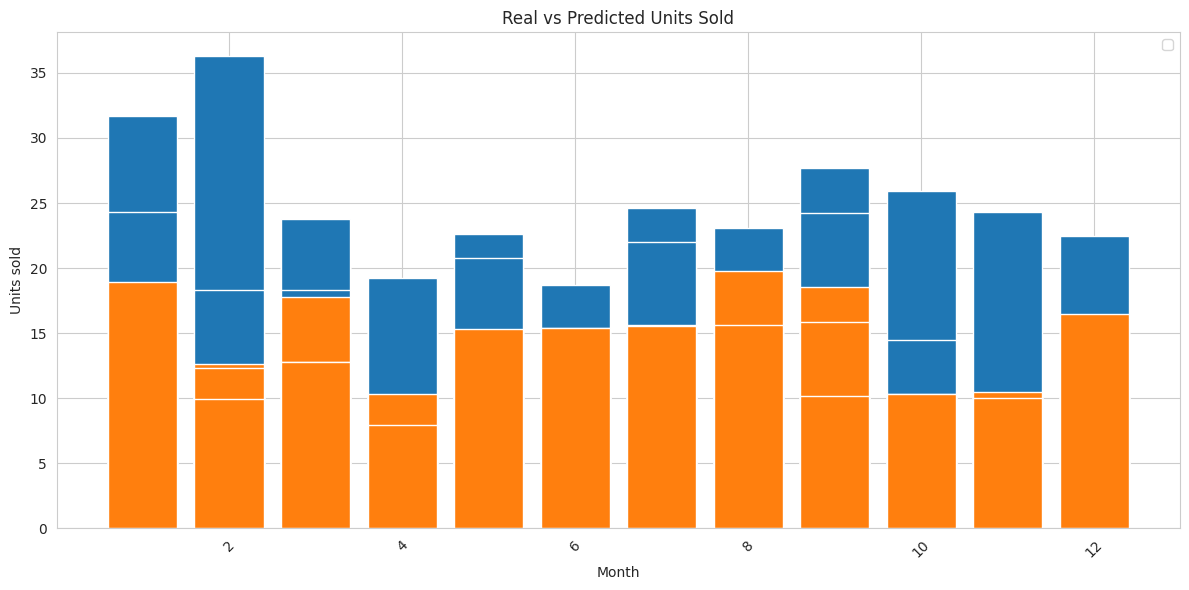

In [ ]:
# Visualize real and predicted values
plt.figure(figsize=(12, 6))
plt.bar(data_train['month'], data_train["units_sold"])
plt.bar(X_test['month'], y_pred)
plt.title('Real vs Predicted Units Sold')
plt.xlabel('Month')
plt.ylabel('Units sold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['baseline_lr'],
                        'R2': [r2_test],
                        'MAE': [mae_test],
                        'MAPE': [mape_test],
                        'Special model parameters':
                         ["-"]})

# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

,Model,R2,MAE,MAPE,Special model parameters
0,baseline_lr,0.174495,2.904036,0.246576,-


##### df_cleaned

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_predict
import pandas as pd

# Define regression models
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(verbosity=-1, random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)
}

reports = []

# Iterate over models
for name, model in models.items():
    print(name)
    # Predict using cross-validation
    y_pred_train = cross_val_predict(estimator=model, X=X_train_cleaned_scaled, y=y_train, cv=5)
    y_pred_test = cross_val_predict(estimator=model, X=X_test_cleaned_scaled, y=y_test, cv=5)

    # Calculate metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

    # Print and store results
    print(f"Train - R2: {r2_train}, MAE: {mae_train}, MAPE: {mape_train}")
    print(f"Test - R2: {r2_test}, MAE: {mae_test}, MAPE: {mape_test}")
    print('---' * 25)

    report_dict = {
        'Name': name,
        'R2 Train': r2_train,
        'R2 Test': r2_test,
        'MAE Train': mae_train,
        'MAE Test': mae_test,
        'MAPE Train': mape_train,
        'MAPE Test': mape_test
    }

    reports.append(report_dict)

# Create DataFrame and display
reports_df = pd.DataFrame(reports)
sorted_df = reports_df.sort_values(by='R2 Test', ascending=False)
display(sorted_df)

LinearRegression
Train - R2: 0.6065325803088987, MAE: 2.2192743007031837, MAPE: 0.19652016978914474
Test - R2: -0.3815215809174066, MAE: 3.7735570679499775, MAPE: 0.3293927607933426
---------------------------------------------------------------------------
DecisionTreeRegressor
Train - R2: 0.647595474222002, MAE: 1.8250393081761005, MAPE: 0.16237862032035327
Test - R2: -0.6644581278021857, MAE: 4.045440251572327, MAPE: 0.35192796637043855
---------------------------------------------------------------------------
RandomForestRegressor
Train - R2: 0.7425324564202368, MAE: 1.6866388283100544, MAPE: 0.15119322005118627
Test - R2: -0.2667514866629501, MAE: 3.8377381537749455, MAPE: 0.3550962866861979
---------------------------------------------------------------------------
LGBMRegressor
Train - R2: 0.7207046342211116, MAE: 1.7618124494761513, MAPE: 0.15132103808358185
Test - R2: -0.15974577827818925, MAE: 3.4323474630246245, MAPE: 0.30838019829517604
------------------------------------

,Name,R2 Train,R2 Test,MAE Train,MAE Test,MAPE Train,MAPE Test
4,XGBRegressor,0.724263,-0.088676,1.751243,3.463438,0.164078,0.300403
3,LGBMRegressor,0.720705,-0.159746,1.761812,3.432347,0.151321,0.308380
5,GradientBoostingRegressor,0.741755,-0.238527,1.603339,3.820475,0.142818,0.344619
2,RandomForestRegressor,0.742532,-0.266751,1.686639,3.837738,0.151193,0.355096
0,LinearRegression,0.606533,-0.381522,2.219274,3.773557,0.196520,0.329393
1,DecisionTreeRegressor,0.647595,-0.664458,1.825039,4.045440,0.162379,0.351928


CONCLUSION: Due to the very small amount of data, deleting rows with outliers leads to worse results. Therefore, I will continue training using the full dataset.

### LinearRegression Tuning


#### HtperOpt

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score

# Define the hyperparameter space
space = {
    'model': hp.choice('model', [
        {
            'type': 'linear',
            'fit_intercept': hp.choice('fit_intercept_linear', [True, False]),
        },
        {
            'type': 'ridge',
            'alpha': hp.uniform('alpha_ridge', 0.01, 10.0),  # Regularization strength
            'fit_intercept': hp.choice('fit_intercept_ridge', [True, False]),
        },
        {
            'type': 'lasso',
            'alpha': hp.uniform('alpha_lasso', 0.01, 10.0),  # Regularization strength
            'fit_intercept': hp.choice('fit_intercept_lasso', [True, False]),
        }
    ]),
}

def hyperopt_linear(params, cv=5, X=X_train, y=y_train):
    model_type = params['model']['type']

    if model_type == 'linear':
        model = LinearRegression(fit_intercept=params['model']['fit_intercept'])
    elif model_type == 'ridge':
        model = Ridge(alpha=params['model']['alpha'], fit_intercept=params['model']['fit_intercept'])
    elif model_type == 'lasso':
        model = Lasso(alpha=params['model']['alpha'], fit_intercept=params['model']['fit_intercept'])

    score = cross_val_score(model, X, y, cv=cv, scoring="r2").mean()
    return -score

trials = Trials()
best = fmin(hyperopt_linear,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42)
           )

print(f"Best hyperparameter values: {best}")

100%|██████████| 100/100 [00:05<00:00, 17.59trial/s, best loss: -0.542993650116476]
Best hyperparameter values: {'alpha_ridge': 1.7374055617565864, 'fit_intercept_ridge': 0, 'model': 1}


In [ ]:
# Let's continue to look for the most optimal parameters

best = fmin(hyperopt_linear,  # our function
            space=space,  # hyperparameter space
            algo=tpe.suggest,  # optimization algorithm, set by default, not required to specify
            max_evals=1300,  # maximum number of iterations
            trials=trials,  # logging results
            rstate=np.random.default_rng(42)  # set for result reproducibility
           )
print(f"Best hyperparameter values: {best}")

100%|██████████| 1300/1300 [00:21<00:00, 13.99trial/s, best loss: -0.5429938064277265]
Best hyperparameter values: {'alpha_ridge': 1.7097753932119943, 'fit_intercept_ridge': 0, 'model': 1}


In [ ]:
best_params = {
    'type': ['linear', 'ridge', 'lasso'][best['model']],
    'fit_intercept': bool(best['fit_intercept_linear' if best['model'] == 0 else 'fit_intercept_ridge' if best['model'] == 1 else 'fit_intercept_lasso']),
    'alpha': best['alpha_ridge' if best['model'] == 1 else 'alpha_lasso']  # Only used for Ridge and Lasso
}

if best_params['type'] == 'linear':
    model = LinearRegression(fit_intercept=best_params['fit_intercept'])
elif best_params['type'] == 'ridge':
    model = Ridge(alpha=best_params['alpha'], fit_intercept=best_params['fit_intercept'])
elif best_params['type'] == 'lasso':
    model = Lasso(alpha=best_params['alpha'], fit_intercept=best_params['fit_intercept'])

print("Best hyperparameters:", best_params)
model

Best hyperparameters: {'type': 'ridge', 'fit_intercept': False, 'alpha': 1.7097753932119943}


Ridge(alpha=1.7097753932119943, fit_intercept=False)

In [ ]:
# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate evaluation metrics for the training set
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

# Calculate evaluation metrics for the test set
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Print evaluation metrics for the training set
print("Training Set Metrics:")
print("R2:", r2_train)
print("MAE:", mae_train)
print("MAPE:", mape_train)
print('---' * 15)
# Print evaluation metrics for the test set
print("\nTest Set Metrics:")
print("R2:", r2_test)
print("MAE:", mae_test)
print("MAPE:", mape_test)

Training Set Metrics:
R2: 0.3469480559525714
MAE: 2.8569985880589908
MAPE: 0.2316064330630057
---------------------------------------------

Test Set Metrics:
R2: 0.174499880221205
MAE: 2.9040205071829215
MAPE: 0.24657592403520198


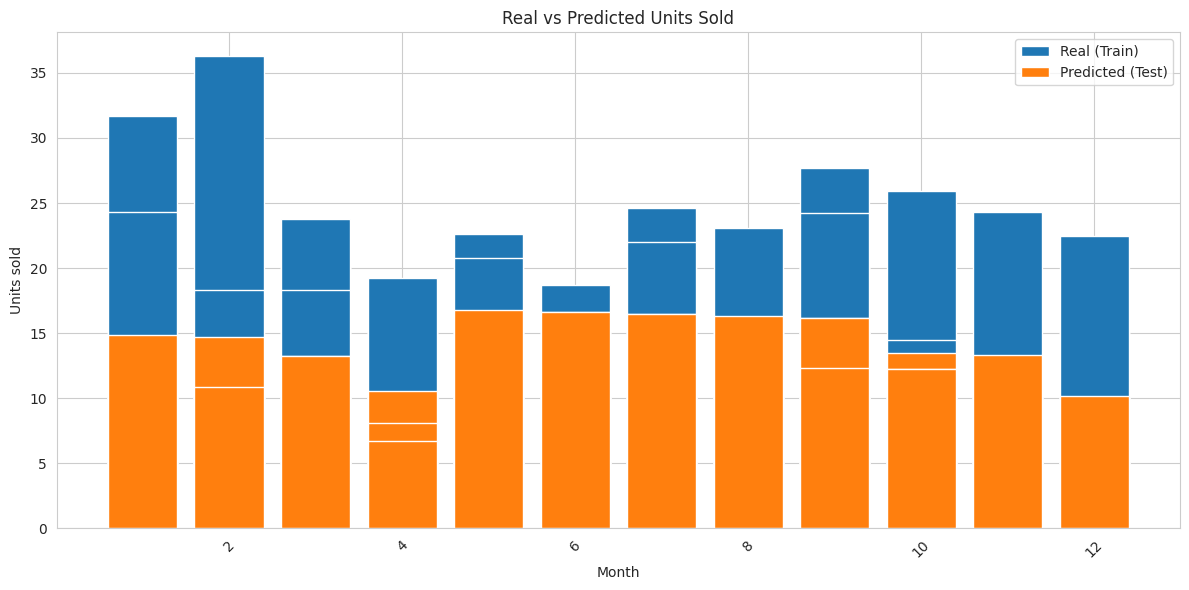

In [ ]:
# Visualize real and predicted values for the test set
plt.figure(figsize=(12, 6))
plt.bar(data_train['month'], data_train["units_sold"], label='Real (Train)')
plt.bar(X_test['month'], y_pred_test, label='Predicted (Test)')
plt.title('Real vs Predicted Units Sold')
plt.xlabel('Month')
plt.ylabel('Units sold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['lr'],
                        'R2': [r2_test],
                        'MAE': [mae_test],
                        'MAPE': [mape_test],
                        'Special model parameters':
                         ["-"]})

# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

,Model,R2,MAE,MAPE,Special model parameters
0,baseline_lr,0.174495,2.904036,0.246576,-
1,lr,0.174495,2.904036,0.246576,-


The model does not predict well yet

#### PolynomialFeatures

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Define the polynomial degree
degree = 2

# Create the polynomial model
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the model on the training set
poly_model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_pred_train = poly_model.predict(X_train)
y_pred_test = poly_model.predict(X_test)

# Evaluate the model's performance on the training set
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

# Evaluate the model's performance on the test set
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Print evaluation metrics for the training set
print("Training Set Metrics:")
print("R2:", r2_train)
print("MAE:", mae_train)
print("MAPE:", mape_train)
print('---' * 15)
print("\nTest Set Metrics:")
print("R2:", r2_test)
print("MAE:", mae_test)
print("MAPE:", mape_test)

Training Set Metrics:
R2: 0.7949286803287153
MAE: 1.5596609266088255
MAPE: 0.13829856920730962
---------------------------------------------

Test Set Metrics:
R2: 0.6747951767863394
MAE: 1.6161942871533472
MAPE: 0.1406249567550565


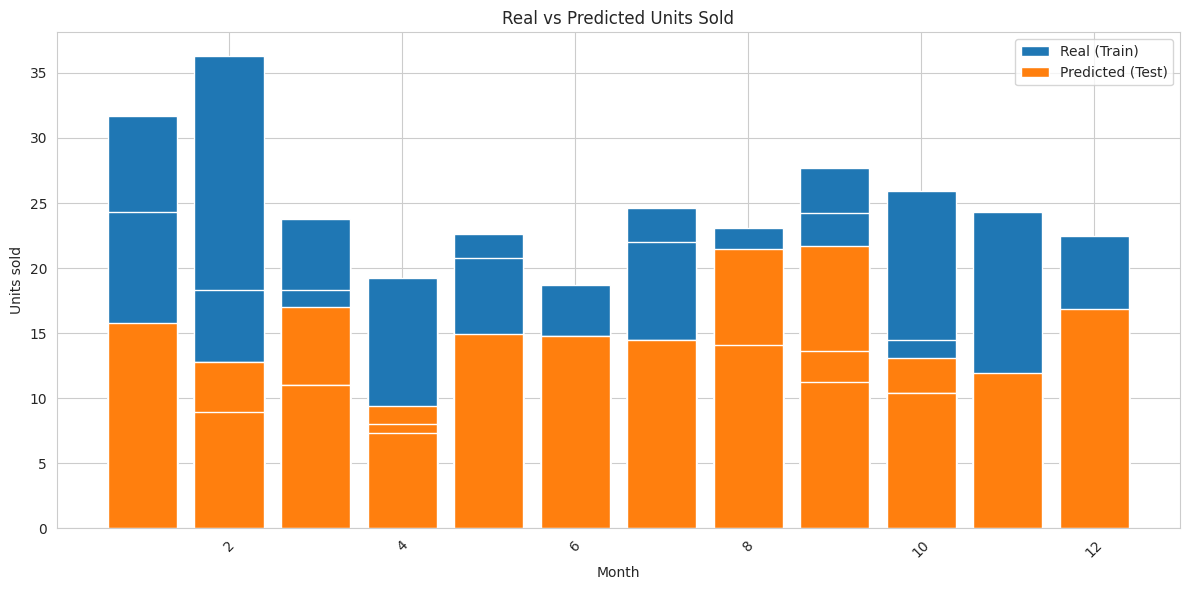

In [ ]:
# Visualize real and predicted values for the test set
plt.figure(figsize=(12, 6))
plt.bar(data_train['month'], data_train["units_sold"], label='Real (Train)')
plt.bar(X_test['month'], y_pred_test, label='Predicted (Test)')
plt.title('Real vs Predicted Units Sold')
plt.xlabel('Month')
plt.ylabel('Units sold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['poly_model'],
                        'R2': [r2_test],
                        'MAE': [mae_test],
                        'MAPE': [mape_test],
                        'Special model parameters':
                         ["-"]})

# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

,Model,R2,MAE,MAPE,Special model parameters
0,baseline_lr,0.174495,2.904036,0.246576,-
1,lr,0.174495,2.904036,0.246576,-
2,poly_model,0.674795,1.616194,0.140625,-


Conclusion: The model trained on polynomial features showed the best result

In [ ]:
from joblib import dump

# Define the file path to save the model
model_filename = 'polynomial_regression_model.joblib'

# Save the model to disk
dump(poly_model, model_filename)

print("Polynomial regression model saved successfully.")

Polynomial regression model saved successfully.


## Model Testing

In [ ]:
import joblib

# Load the model from the file
loaded_model = joblib.load('polynomial_regression_model.joblib')
loaded_model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [ ]:
data_test.head()

,unit_price,units_sold,year,month
0,8.980,???,2024,4
1,8.980,???,2024,5
2,8.980,???,2024,5
3,5.388,???,2024,5
4,8.980,???,2024,5


In [ ]:
# Extract features from the test data
features = ['unit_price', 'year', 'month']

X_test = data_test[features]

# Predict the responses for the test dataset
y_pred = loaded_model.predict(X_test)


# Add the predicted values to the test data
data_test['Predicted units sold(000s)'] = y_pred

# Print the updated test data with predicted values
print(data_test)

    unit_price units_sold  year  month  Predicted units sold(000s)
0        8.980        ???  2024      4                    7.338866
1        8.980        ???  2024      5                    7.629302
2        8.980        ???  2024      5                    7.629302
3        5.388        ???  2024      5                   64.019580
4        8.980        ???  2024      5                    7.629302
5        8.980        ???  2024      6                    7.823077
6        8.980        ???  2024      6                    7.823077
7        7.900        ???  2024      6                   15.606653
8        7.900        ???  2024      6                   15.606653
9        8.980        ???  2024      6                    7.823077
10       8.980        ???  2024      7                    7.920191
11       8.980        ???  2024      7                    7.920191
12       7.500        ???  2024      7                   21.422961
13       8.980        ???  2024      7                    7.92

In [ ]:
y_pred

array([  7.33886582,   7.62930217,   7.62930217,  64.01957953,
         7.62930217,   7.82307718,   7.82307718,  15.60665318,
        15.60665318,   7.82307718,   7.92019083,   7.92019083,
        21.42296077,   7.92019083,   7.92064313,   7.92064313,
         7.92064313,   7.92064313,   7.82443408,   7.82443408,
         7.82443408,   7.82443408,   7.82443408,   7.63156368,
        28.66858057,   7.63156368,   7.63156368,   7.34203193,
         7.34203193,   7.34203193,   7.34203193,   4.71572198,
         4.71572198,  66.32350255,  66.32350255,   4.71572198,
         5.68667878,   5.68667878,   5.68667878,   5.68667878,
         6.48732104,   6.48732104,   6.48732104,   6.48732104,
       108.22505274,   7.19130195,   7.19130195,   7.19130195,
         7.19130195,   7.79862151,   7.79862151,   7.79862151,
         7.79862151])

In [ ]:
data_tt['Predicted units sold(000s)'] = y_pred

In [ ]:
# Save DataFrame to CSV file
data_tt.to_csv('predicted_units_sold.csv', index=False)
